EPSG:25833
BoundingBox(left=391688.1352, bottom=5816723.5617, right=394900.3042, top=5819450.5491)
(array([   0,    0,    0, ..., 2726, 2726, 2726]), array([   0,    1,    2, ..., 3209, 3210, 3211]))


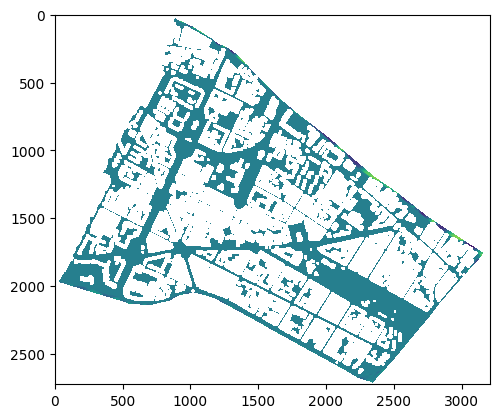

In [21]:
import shapefile  # pip install pyshp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import math
import random
from geopy import distance
import swmmio
import pyswmm
from pyswmm import Simulation,Subcatchments
import math
import pickle
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point, box
import tifffile
import rasterio
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import os  
from scipy import ndimage

x_shift = 391688#extent coordinates
y_shift = 5816723#extent coordinates

path_tif = "/Users/siruiwang/hyspec4eo/inno_maus/r2d_bln1_swmm_r_145mm_0U.tif"#read any tif file from ground truth H, V, U

# Define the paths to SWMM model files
inp_file = '/Users/siruiwang/hyspec4eo/inno_maus/nowcast_innomaus_berlin_SWMM_local17042025/Berlin_I.inp'

path = "/Users/siruiwang/hyspec4eo/inno_maus/nowcast_innomaus_berlin_SWMM_local17042025"   #path for txt runoff files
path_save = "/Users/siruiwang/hyspec4eo/inno_maus/output/" #path for saving the output files
#however, the output files are saved in the same folder. please manage the output files in the different folders before run the save_pt ipynb
#example: output/b/b_100m/b_100mm_runoff_swmm_1200.tif
data= tifffile.imread(path_tif)
map=rasterio.open(path_tif)
print(map.crs)
print(map.bounds)
extent1 = [map.bounds[0], map.bounds[1], map.bounds[2], map.bounds[3]]
print(np.where(data!='nan'))
plt.imshow(data)
plt.show()
zoom_factor=10
width=int(3212/zoom_factor)
height=int(2727/zoom_factor)
def downsample_img( img, scale_factor=0.125):
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
        img = ndimage.zoom(img, scale_factor, order=1).transpose(2, 0, 1)
    else:
        img = ndimage.zoom(img, scale_factor, order=1)
    return img


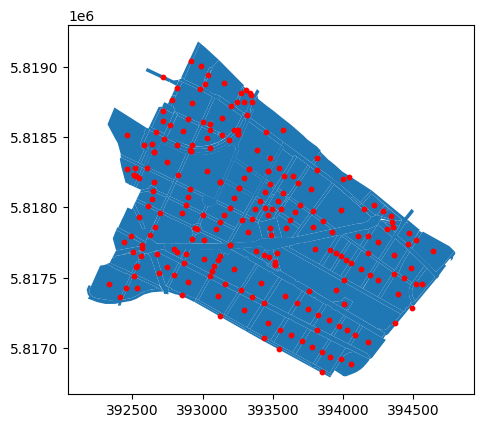

In [12]:


# Import the SWMM model
Bln_1_model=swmmio.Model(inp_file)
subs=Bln_1_model.subcatchments.dataframe
# Reset the index to add the Name of the subcatchments as a column to the dataframe
subs = subs.reset_index()

# convert the coordinates to a polygon coordination that can be used by geopandas
subs['geometry']=subs['coords'].apply(lambda coords: Polygon(coords))

# Create a GeoDataFrame with the specified CRS
subs = gpd.GeoDataFrame(subs, geometry='geometry', crs='EPSG:25833')

# drop unnecessary data
subs.drop(columns=['Raingage', 'Outlet', 'PercImperv', 'Width',
       'PercSlope', 'CurbLength', 'N-Imperv', 'N-Perv', 'S-Imperv', 'S-Perv',
       'PctZero', 'RouteTo', 'PctRouted', 
        'coords', 'Area'],inplace=True)


# Create a new column with the center points of the polygons
subs['center_point'] = subs['geometry'].centroid
# Plot the GeoDataFrame
ax = subs.plot()

# Plot the center points on the same plot
subs['center_point'].plot(ax=ax, color='red', markersize=10)

extent2 = subs.total_bounds
extent = [min(extent1[0],extent2[0]), min(extent1[1],extent2[1]), max(extent1[2],extent2[2]), max(extent1[3],extent2[3])]

231
231
0


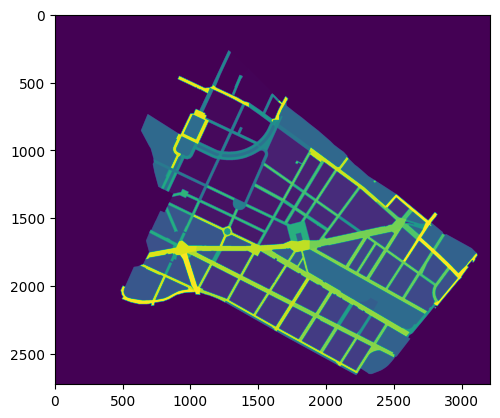

In [13]:
# Create a raster with the same subcatchment id as the subcatchment
from rasterio.features import rasterize

#convert from subs  to raster
# Create a raster with the same extent as the map
raster = np.zeros((data.shape[0], data.shape[1]))
#give the point id as polygon value
# Define transform for raster (mapping between pixel coordinates and spatial coordinates)
transform = rasterio.transform.from_origin(extent[0], extent[3], 1, 1)
print(len(subs))
shapes = ((geom,value) for geom, value in zip(subs['geometry'], range(1, len(subs)+1)))
raster = rasterize(shapes=shapes, out_shape=(data.shape[0], data.shape[1]), transform=transform, fill=0, all_touched=True, dtype='int32')
plt.imshow(raster)

print(np.max(raster))
print(np.min(raster))



In [14]:


def get_nearest_runoff_value(px,py,data_txt_sum,subs,extent):
    x = px+extent[0]
    y = py+extent[1]
    point = Point(x,y)
    points = subs['center_point']
    distances = points.distance(point)
    nearest_point_id = distances.idxmin()
    return data_txt_sum[nearest_point_id]

#save to tif with projection


def save_to_tif(extent,file_name,image):

    # Set the transform with the upper left corner and the pixel size
    transform = from_origin(extent[0], extent[3], 1, 1)
    save_new_map = image.transpose(2,0,1)
    # Set the metadata
    meta = {
    'driver': 'GTiff',
    'height': save_new_map.shape[1],
    'width': save_new_map.shape[2],
    'count': save_new_map.shape[0],
    'dtype': save_new_map.dtype,
    'crs': CRS.from_epsg(25833),
    'transform': transform,
    'compress': 'lzw',
    'nodata': np.nan
    }

    # Write the raster to disk
    with rasterio.open(file_name, 'w', **meta) as dst:
        dst.write(save_new_map, indexes=[1])
        dst.nodata =np.nan
        dst.crs = CRS.from_epsg(25833)
        dst.transform = transform
        dst.close()

    # Open the raster file
    with rasterio.open(file_name) as src:
        #print(src.profile)
        #print(src.crs)
        #print(src.transform)
        #print(src.bounds)
        #print(src.width)
        #print(src.height)
        #print(src.count)
        #print(src.nodata)
        data = src.read(1)
        #plt.imshow(data)
        #plt.show()
def get_runoff_from_shp(shp_path):
    """
    get shape file data
    :param shp_path: shapefile path
    :return: runoff data
    """
    # read Shapefile
    sf = shapefile.Reader(shp_path)

    # initialize runoff data array
    data_runoff = np.zeros((237))

    for runoff in sf.shapeRecords():
        # get shape and attributes
        shape = runoff.shape
        record = runoff.record

        # print shape and attributes
        field_value = record[0]  # ajust based on actual field index
        runoffcoef = record[2]  
        data_runoff[int(field_value)-1] = runoffcoef

    return data_runoff
def get_coef_from_dat(dat_path):
    """
    get dat file data
    :param dat_path: dat file path
    :return: runoff data
    """
    # read dat file
    data = pd.read_csv(dat_path, sep="\t", header=None, skiprows=0)
    # set column name
    data.columns = ['Runoff']
    
    # initialize runoff coefficient array
    data_coef = np.zeros((len(data['Runoff'].values)))
    
    for i in range(len(data['Runoff'].values)):
        s = data['Runoff'].values[i]
        value = float(s.split()[-1])
        data_coef[i] = value

    return data_coef
def get_real_runoff(runoff_data, coef_data):
    """
    get real runoff data
    :param runoff_data: runoff data
    :param coef_data: coefficient data
    :return: real runoff data
    """
    # initialize real runoff data array
    real_runoff = np.zeros((len(runoff_data), len(coef_data)))
    
    for i in range(len(coef_data)):
        for j in range(len(runoff_data)):
            real_runoff[j][i] = runoff_data[j] * coef_data[i]
    return real_runoff


(237, 16)
3211.1689999999944 2726.9873999999836
(2727, 3212, 16)


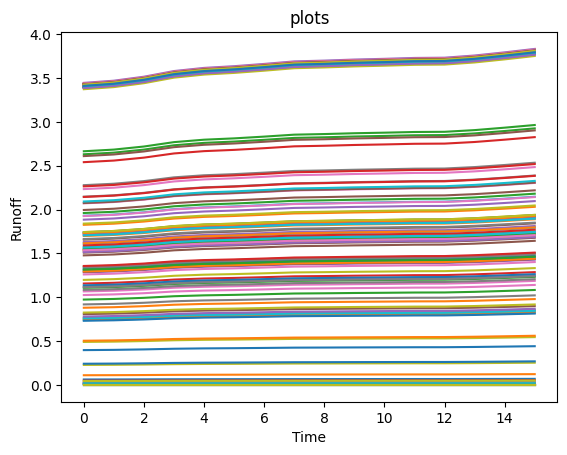

In [22]:
dat_path = "/Users/siruiwang/hyspec4eo/inno_maus/nowcast_innomaus_berlin_SWMM_local17042025/Moabit_02_Aug_2019_file.dat"  # change to your dat file path
shp_path = "/Users/siruiwang/hyspec4eo/inno_maus/nowcast_innomaus_berlin_SWMM_local17042025/subs.shp"  # change to your shapefile path

if os.path.exists(shp_path) and os.path.exists(dat_path):
    # Read the shapefile and dat file
        runoff_data = get_runoff_from_shp("/Users/siruiwang/hyspec4eo/inno_maus/nowcast_innomaus_berlin_SWMM_local17042025/subs.shp")
        coef_data = get_coef_from_dat(dat_path)
        real_runoff = get_real_runoff(runoff_data, coef_data)
        print(real_runoff.shape)
        fig=plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title('plots')
        ax.set_xlabel('Time')
        ax.set_ylabel('Runoff')
        for i in range(0,subs.shape[0]):
            ax.plot(real_runoff[i])
        width_o = extent[2] - extent[0]-1
        height_o = extent[3] - extent[1]
        print(width_o,height_o)
        new_map = np.zeros((math.ceil(height_o),math.ceil(width_o),real_runoff.shape[1]))
        for px in range(0,math.ceil(width_o)):
            for py in range(0,math.ceil(height_o)):
                if raster[math.ceil(height_o)-py-1,px-1] != 0:
                    new_map[math.ceil(height_o)-py-1,px-1,:] = real_runoff[int(raster[math.ceil(height_o)-py-1,px-1])-1]
        print(new_map.shape)
        #new_map[np.where(raster==0)] = np.nan
        file_name = path_save+"test_2024_0528"
        folder_name = file_name.split("_runoff_swmm")[0].split("/")[-1]
        os.makedirs(path_save+folder_name, exist_ok=True)
        for i in range(0,len(new_map[0,0,:])):
            file_name = path_save+folder_name+"/"+"test_2024_0528"+"_"+str(i*300)+".tif"
            img= downsample_img(new_map[:,:,i], scale_factor=1/zoom_factor)[:height,:width]
            save_to_tif(extent,file_name,img.reshape(math.ceil(height),math.ceil(width),1))
            #print(file_name)

        


(272, 321)


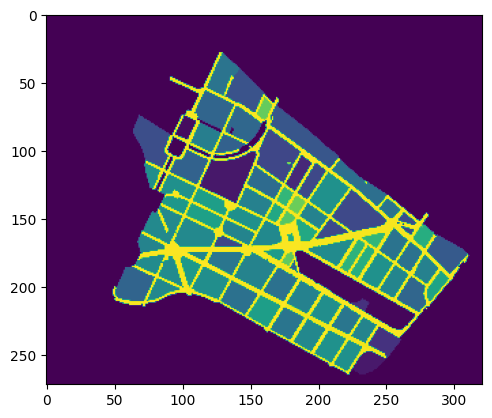

In [23]:
#read tiff
def read_tif(tif_path):
    """
    Read a GeoTIFF file and return the data and metadata.
    :param tif_path: Path to the GeoTIFF file
    :return: Tuple of (data, metadata)
    """
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        metadata = src.meta
    return data, metadata
test=read_tif("/Users/siruiwang/hyspec4eo/inno_maus/output/test_2024_0528/test_2024_0528_4500.tif")
plt.imshow(test[0])
print(test[0].shape)

In [28]:
import os
import torch
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from glob import glob
import tifffile
# process one event files and convert to .pt files
# set up the path
hsv_base_path = None  #path for ground truth tif
dem_path = "/Users/siruiwang/hyspec4eo/inno_maus/dem/DEM.tif" #path for dem tif
runoff_base_path = "/Users/siruiwang/hyspec4eo/inno_maus/output/test_2024_0528" #path for runoff tif, the output from process.ipynb
output_path = "/Users/siruiwang/hyspec4eo/inno_maus/pt" #path for output .pt files
#format of the output file: [height, width, time, channels]
#channels: H, S, V, runoff, dem
os.makedirs(output_path, exist_ok=True)

def read_raster(file_path, target_meta=None):
    #data=  tifffile.imread(file_path)
    """ read the raster file and reproject """
    with rasterio.open(file_path) as src:
        crs = src.crs
        meta = src.meta.copy()
        data = src.read(1)

        # process if crs is none
        if crs is None:
            print(f"Warning: {file_path} has no CRS. Assigning default EPSG:25833.")
            meta['crs'] = "EPSG:25833"  # projection

        if target_meta:
            target_transform = target_meta['transform']
            target_shape = (target_meta['height'], target_meta['width'])

            destination = np.zeros(target_shape, dtype=np.float32)
            reproject(
                source=data,
                destination=destination,
                src_transform=meta['transform'],
                src_crs=meta['crs'],
                dst_transform=target_transform,
                dst_crs=target_meta['crs'],
                resampling=Resampling.bilinear
            )
            return destination

        return data


# read dem
dem_data = read_raster(dem_path)
dem_data = np.nan_to_num(dem_data, nan=75.4477)
with rasterio.open(dem_path) as dem_src:
    dem_meta = dem_src.meta.copy()
    dem_meta.update({"width": 3212, "height": 2727})
    dem_data = downsample_img(dem_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample 

# read data from events
if hsv_base_path is not None:

    event_folders = sorted(glob(os.path.join(hsv_base_path, "*/")))
    for event_folder in event_folders:
        event_name = os.path.basename(os.path.dirname(event_folder))
        print(event_name)
        # read H, S, V files
        path_h = event_folder+ "*H.tif"
        path_u = event_folder+ "*U.tif"
        path_v = event_folder+ "*V.tif"
        h_files = sorted(glob(path_h))
        s_files = sorted(glob(path_u))
        v_files = sorted(glob(path_v))

        data_tensor = np.zeros((height, width, 25, 5), dtype=np.float32)

        for h_file, s_file, v_file in zip(h_files, s_files, v_files):
            # read time index
            time_index = int(os.path.basename(h_file).split("_")[-1].replace("H.tif", ""))
            time_index = min(time_index // 300, 24)  # max limit
        
            # read H, S, V data
            h_data = read_raster(h_file, target_meta=dem_meta)
            h_data = downsample_img(h_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample
            s_data = read_raster(s_file, target_meta=dem_meta)
            s_data = downsample_img(s_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample
            v_data = read_raster(v_file, target_meta=dem_meta)
            v_data = downsample_img(v_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample

            # put into correct location
            data_tensor[:, :, time_index, 0] = h_data
            data_tensor[:, :, time_index, 1] = s_data
            data_tensor[:, :, time_index, 2] = v_data

        # read runoff data
        runoff_folder = os.path.join(runoff_base_path, "r", f"r_{event_name}")
        runoff_files = sorted(glob(os.path.join(runoff_folder, "*.tif")))
        for file in runoff_files:
            time_index = int(os.path.basename(file).split("_")[-1].replace(".tif", ""))
            time_index = min(time_index // 300, 24)
            runoff_data = read_raster(file, target_meta=dem_meta)
            runoff_data = downsample_img(runoff_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample
            print(runoff_data.max())
            data_tensor[:, :, time_index, 3] = runoff_data

        # DEM data
        data_tensor[:, :, :, 4] = np.repeat(dem_data[:, :, np.newaxis], 25, axis=2)
        print(dem_data[10,10],"dem")
        # convert to torch format
        torch_tensor = torch.tensor(data_tensor)
        torch.save(torch_tensor, os.path.join(output_path, f"r_{event_name}.pt"))
else:
    data_tensor = np.zeros((height, width, 16, 5), dtype=np.float32)
    # read runoff data
    runoff_files = sorted(glob(os.path.join(runoff_base_path, "*.tif")))
    for file in runoff_files:
        time_index = int(os.path.basename(file).split("_")[-1].replace(".tif", ""))
        time_index = min(time_index // 300, 24)
        runoff_data = read_raster(file, target_meta=dem_meta)
        runoff_data = downsample_img(runoff_data, scale_factor=1/zoom_factor)[:height, :width]  # downsample
        data_tensor[:, :, time_index, 3] = runoff_data
    # DEM data
    data_tensor[:, :, :, 4] = np.repeat(dem_data[:, :, np.newaxis], 16, axis=2)
    # convert to torch format
    torch_tensor = torch.tensor(data_tensor)
    torch.save(torch_tensor, os.path.join(output_path, f"test.pt"))


print("done!")

done!
